# Предсказание последней буквы слова по Ожегову

Постановка задачи: мульти-классовая классификация буквы, по всем буквам слова кроме последнего

Характиристика данных: в качестве датасета используются слова из словаря Ожегова, и следовательно все слова находятся в начальной форме. В выборке присутсвуют слова разных частей речи

## Подготовка данных

Преобразуем каждое слово в вектор векторов, где каждый внутренний ветор состоит из множества 0й и одной 1. Положение 1 определяет букву. Например 'а' = [1,0,...,0,0], 'б' = [0,1,0,...,0,0] и т.д.

Прим.: будем кодировать только строчные буквы, а заглавные при наличии привидем к строчным

Создадим словарь букв русского языка для кодировки слов нашей выборки

In [92]:
vocabulary = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р',
'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '-']

Считаем данные и сделаем базовые преобразования строк

In [93]:
#Проверяет на то содержит ли строка только символы из словаря
def check_on_voc(x, vocabulary):
    for i in x:
        if i not in vocabulary:
            return False
    return True

In [94]:
import numpy as np
#Считываем данные
lines = []
with open('2.txt') as f:
    lines = f.readlines()
#Удаляем из данных сносы строк, кареток и т.п, а также приводим буквы к строчным
lines = (list(map(lambda x : x.rstrip().lower(),lines)))
#Удаляем слова из одной буквы
lines = list(filter(lambda x : len(x)>1, lines))
#Удаляем слова в которых есть символы не из словаря
lines = list(filter(lambda x : check_on_voc(x, vocabulary), lines))

In [95]:
#Массив фичей - слов без последней буквы
X =  np.array(list(map(lambda x : x[:-1],lines)))
#Массив таргетов - последних букв слов
y =  np.array(list(map(lambda x : x[-1],lines)))

In [96]:
#Создадим два QA словаря для быстрого перевода букв в индексы и индексов в буквы
def get_vocab_dictionaries(vocabulary):
    item_to_ind = {}
    ind_to_item = {}
    for ind, item in enumerate(vocabulary):
        item_to_ind[item] = ind
        ind_to_item[ind] = item
    return item_to_ind, ind_to_item
item_to_ind, ind_to_item = get_vocab_dictionaries(vocabulary)
length = len(vocabulary)

In [97]:
#Создание вектора из одной буквы(в четком определении слова)
def create_vector(word):
    global item_to_ind, ind_to_item, length
    result = [0]*length
    for i in word:
        if i in item_to_ind.keys():
            result[item_to_ind[i]] = 1
    return result

#Создание списка векторов из букв слова
def create_vector_array(word):
    result = []
    for i in word:
        result.append(create_vector(i))
    return result

#Перевод вектора обратно в букву
def vector_to_letter(vector):
    global item_to_ind, ind_to_item, length
    result = ""
    for ind, item in enumerate(vector):
        if item == 1:
            result+=ind_to_item[ind]
    return result

#Перевод списка векторов обратно в слово
def vector_array_to_word(vector_array):
    result = ""
    for i in vector_array:
        result += vector_to_letter(i)
    return result

In [98]:
#Преобразование слов в собственно векторный вид
X = list(map(lambda x : np.array(create_vector_array(x)),list(X)))
y = list(map(lambda x : np.array(create_vector(x)), list(y)))

In [99]:
from torch.utils.data import Dataset
#Кастомный класс для хранения данных
class LetterDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
train_size = 0.7
#Разобьем наши выборки на тестовые и тренировачные
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42, shuffle=True)

#Создаем датасеты
train_dataset = LetterDataset(X_train, y_train)
test_dataset = LetterDataset(X_test, y_test)

#Создаем даталоадеры
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Описание модели и функций обучения

In [101]:
import torch.nn as nn
#Модель нейронной сети для обучения
class LetterNetwork(nn.Module):
    #Конструктор
    def __init__(self, length, hidden_dim, n_layers):
        super().__init__()
        self.length = length
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        #Основа рекуретной сети - воспользуемся ЛСТМ
        self.rnn = nn.LSTM(length, hidden_dim, n_layers, batch_first=True)
        #Приведение вывода лстм к необходимому формату
        self.out_layer = nn.Sequential(
            nn.Linear(hidden_dim, length*2),
            nn.Sigmoid(),
            nn.Linear(length*2, length),
            nn.Softmax()
        )
    #Применение слоев к пришедшему батчу
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        hidden, carry = torch.randn(self.n_layers, len(x), self.hidden_dim), torch.randn(self.n_layers, len(x), self.hidden_dim)
        out, (hidden, carry) = self.rnn(x, (hidden, carry))
        out = out[:,-1]
        out = self.out_layer(out)
        return out

In [102]:
#Функция предсказания датасета моделью
def predict(model, dataset):
    result = []
    for x, y in dataset:
        result.append(model([x])[0].detach().numpy())
    return result

In [103]:
#Функция для преобразования каждого вектора в индекс соответсвующий его буквы 
def get_classes(items):
    result = []
    for arr in items:
        ind = np.unravel_index(arr.argmax(), arr.shape)[0]
        result.append(ind)
    return result

In [104]:
def plot_on_axis(axs, tittle, i, num_epochs, train, test):
    axs.set_title(f"{tittle} {i+1}/{num_epochs}")
    axs.set_xlabel("Epoch")
    axs.set_ylabel(tittle)
    tr, = axs.plot(train, 'b')
    te, =axs.plot(test, 'r')
    axs.legend([tr, te], ['train', 'test'])

In [105]:
from IPython import display
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score, precision_score
#Функция обучения модели
def learn(model, optimizer, num_epochs, criterion, train_dataloader, train_dataset, test_dataset, y_train, y_test):
    acc_history_test = []
    acc_history_train = []
    rec_history_test = []
    rec_history_train = []
    prec_history_test = []
    prec_history_train = []
    epoch_loss_history = []
    loss_history = []
    strings = []
    for i in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dataloader:
            predictions = model.forward(x_batch)            
            loss = criterion(predictions, torch.tensor(y_batch,dtype=torch.float32))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad() 
        model.eval()
        #Рисуем графики и проводим промежуточную валдиацию модели 
        with torch.no_grad():
            epoch_loss_history.append(loss.item())
            fig, axs = plt.subplots(nrows= 3, ncols= 1,  figsize=(10,15))
            display.clear_output(wait=True)

            acc_test = predict(model, test_dataset)
            acc_history_test.append(accuracy_score(get_classes(acc_test), get_classes(y_test)))

            acc_train = predict(model, train_dataset)
            acc_history_train.append(accuracy_score(get_classes(acc_train), get_classes(y_train)))

            rec_test = predict(model, test_dataset)
            rec_history_test.append(recall_score(get_classes(rec_test), get_classes(y_test), average='micro'))

            rec_train = predict(model, train_dataset)
            rec_history_train.append(recall_score(get_classes(rec_train), get_classes(y_train), average='micro'))

            prec_test = predict(model, test_dataset)
            prec_history_test.append(precision_score(get_classes(prec_test), get_classes(y_test), average='micro'))

            prec_train = predict(model, train_dataset)
            prec_history_train.append(precision_score(get_classes(prec_train), get_classes(y_train), average='micro'))

            plot_on_axis(axs[0], 'Accuracy score', i, num_epochs, acc_history_train, acc_history_test)
            plot_on_axis(axs[1], 'Recall score', i, num_epochs, rec_history_train, rec_history_test)
            plot_on_axis(axs[2], 'Precision score', i, num_epochs, prec_history_train, prec_history_test)

            plt.show()
            strings.append(f'{i+1}/{num_epochs} current accuracy loss: {acc_history_train[i]}')
            for s in strings:
                print(s) 

## Обучение

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to 

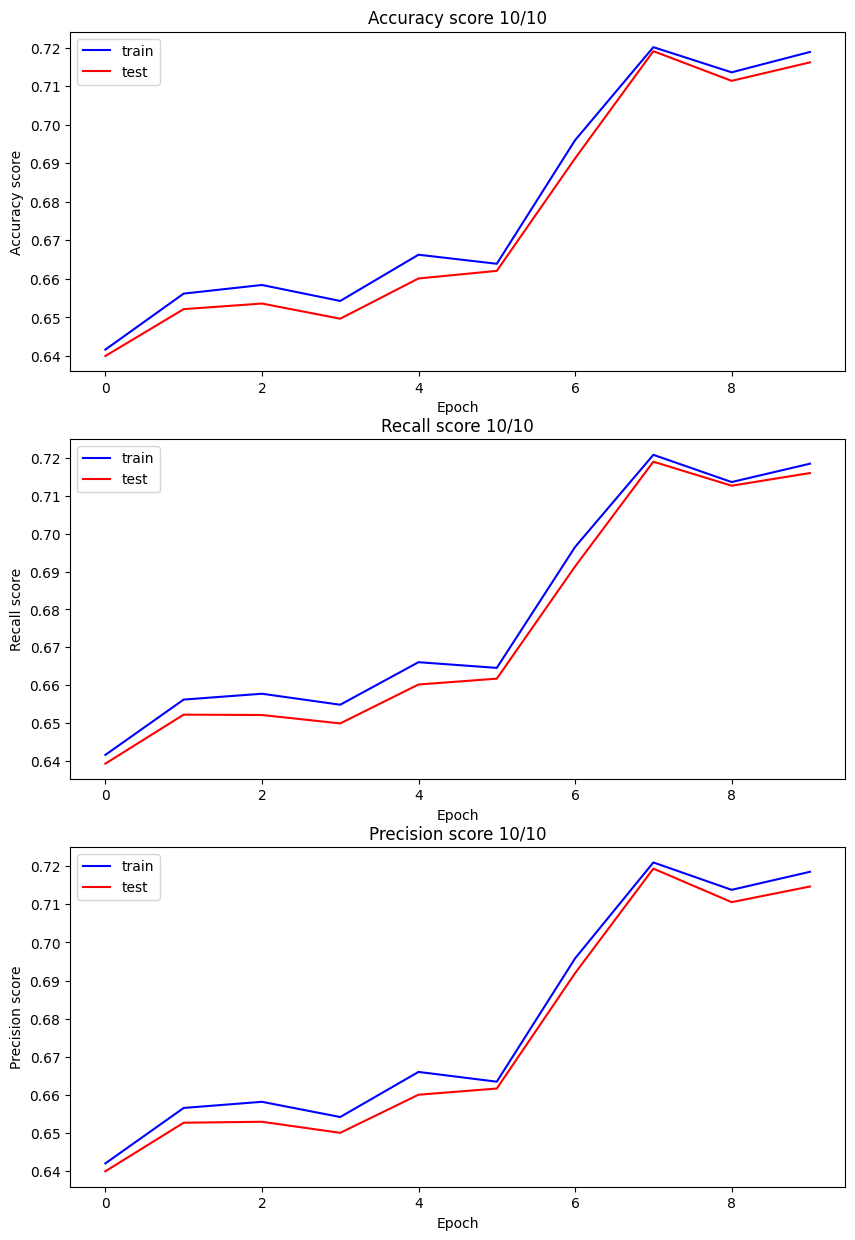

1/10 current accuracy loss: 0.641660250064166
2/10 current accuracy loss: 0.6561801048656181
3/10 current accuracy loss: 0.6584167491658417
4/10 current accuracy loss: 0.6542734572654273
5/10 current accuracy loss: 0.6662633373666264
6/10 current accuracy loss: 0.6639166941663917
7/10 current accuracy loss: 0.6959630403695963
8/10 current accuracy loss: 0.7200894657720089
9/10 current accuracy loss: 0.7135628643713563
10/10 current accuracy loss: 0.7188428115718842


In [106]:
from torch.optim import Adam
#Запустим обучение

epochs = 10
learning_rate = 4e-3
loss_fn = nn.CrossEntropyLoss()

letter_net = LetterNetwork(length, 16, 1)
optimizer = torch.optim.AdamW(letter_net.parameters(), lr=learning_rate)

learn(letter_net, optimizer, epochs, loss_fn, train_dataloader, train_dataset, test_dataset, y_train, y_test)

In [115]:
letter_net

LetterNetwork(
  (rnn): LSTM(34, 16, batch_first=True)
  (out_layer): Sequential(
    (0): Linear(in_features=16, out_features=68, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=68, out_features=34, bias=True)
    (3): Softmax(dim=None)
  )
)

## Подведение итогов, метрик

In [107]:
def predict_letter(model, word):
    ten = model([create_vector_array(word)])[0]
    temp = []
    for i in ten:
        if i == torch.max(ten):
            temp.append(1)
        else:
            temp.append(0)
    return word+vector_to_letter(temp)

def predict_n_letters(model, word, counter):
    for i in range(counter):    
        word = predict_letter(model, word)
    return word

In [108]:
acc_test = predict(letter_net, test_dataset)
acc_test_score = accuracy_score(get_classes(acc_test), get_classes(y_test))

acc_train = predict(letter_net, train_dataset)
acc_train_score = accuracy_score(get_classes(acc_train), get_classes(y_train))

rec_test = predict(letter_net, test_dataset)
rec_test_score = (recall_score(get_classes(rec_test), get_classes(y_test), average='micro'))

rec_train = predict(letter_net, train_dataset)
rec_train_score = (recall_score(get_classes(rec_train), get_classes(y_train), average='micro'))

prec_test = predict(letter_net, test_dataset)
prec_test_score = (precision_score(get_classes(prec_test), get_classes(y_test), average='micro'))

prec_train = predict(letter_net, train_dataset)
prec_train_score = (precision_score(get_classes(prec_train), get_classes(y_train), average='micro'))

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to 

In [114]:
print(f'Accuracy score on train: {acc_train_score}')
print(f'Accuracy score on test: {acc_test_score}')
print(f'Recall score on train: {rec_train_score}')
print(f'Recall score on test: {rec_test_score}')
print(f'Precision score on train: {prec_train_score}')
print(f'Precision score on test: {prec_test_score}')

Accuracy score on train: 0.718439482271844
Accuracy score on test: 0.7151167764564975
Recall score on train: 0.7190628093719063
Recall score on test: 0.7161433826674651
Precision score on train: 0.718989476771899
Precision score on test: 0.7158011805971426


In [112]:
words = ['лопата', 'маракуйя', 'олег', 'кринж', 'лес', 'энтропия', 'костя', 'генератор']
count = 1
for str in words:
    print(f'try to predict "{str}"  -->  {predict_n_letters(letter_net, str[:-count], count)}')

try to predict "лопата"  -->  лопать
try to predict "маракуйя"  -->  маракуйа
try to predict "олег"  -->  олер
try to predict "кринж"  -->  крина
try to predict "лес"  -->  лей
try to predict "энтропия"  -->  энтропия
try to predict "костя"  -->  кость
try to predict "генератор"  -->  генератор


In [113]:
words = ['-', 'а', 'й', 'ё', 'у', 'ре', 'м', 'ук']
count = 3
for str in words:
    print(f'try to predict 3 letters on "{str}"  -->  {predict_n_letters(letter_net, str, count)}')

try to predict 3 letters on "-"  -->  -йор
try to predict 3 letters on "а"  -->  аара
try to predict 3 letters on "й"  -->  йара
try to predict 3 letters on "ё"  -->  ёьар
try to predict 3 letters on "у"  -->  урар
try to predict 3 letters on "ре"  -->  рерар
try to predict 3 letters on "м"  -->  мара
try to predict 3 letters on "ук"  -->  укара


In [116]:
words = ['йёй']
count = 100
for str in words:
    print(f'try to predict 100 letters on "{str}"  -->  {predict_n_letters(letter_net, str, count)}')

c:\Users\Oleg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


try to predict 100 letters on "йёй"  -->  йёйарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарарар
